#### Script for making mean yearly wind direction and speed TIF files w/o aggregation

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from pathlib import Path

def calculate_aggregations_and_save_tif(input_nc_file, pressure_level=1000, min_year=None, max_year=None, year_interval=None):
    """
    Calculate wind speed and direction averages at a specified pressure level, and save the results into new GeoTIFF files.
    
    Parameters:
    input_nc_file (str): Path to NetCDF file with wind data.
    pressure_level (int): Pressure level to analyze (default is 1000 mb).
    min_year (int): Optional, minimum year for analysis.
    max_year (int): Optional, maximum year for analysis.
    year_interval (int): Optional, number of years for grouping (e.g., 5 for 5-year intervals, 10 for 10-year intervals). 
                         If None, aggregate over the full available year range.
    
    Output:
    GeoTIFF files containing aggregated results for wind speed and wind direction, named based on the time period.
    """

    # Load the dataset
    ds = xr.open_dataset(input_nc_file, engine='netcdf4')

    # Ensure the 'date' coordinate is in the correct format
    if not np.issubdtype(ds['date'].dtype, np.datetime64):
        ds['date'] = pd.to_datetime(ds['date'].values, format='%Y%m%d')

    # Check if the specified pressure level exists in the dataset
    if 'pressure_level' in ds.coords and pressure_level in ds['pressure_level'].values:
        # Select the specified pressure level
        ds = ds.sel(pressure_level=pressure_level)
    else:
        raise ValueError(f"Pressure level {pressure_level} mb not found in the dataset.")

    # Check if 'u' and 'v' components exist in the dataset
    if 'u' not in ds or 'v' not in ds:
        raise KeyError(f"The dataset does not contain the required 'u' and 'v' wind components.")

    # Calculate wind speed (m/s) from u and v components
    ds['wind_speed'] = np.sqrt(ds['u']**2 + ds['v']**2)

    # Calculate wind direction in degrees, following meteorological convention (0° = North)
    ds['wind_dir'] = (270 - np.rad2deg(np.arctan2(ds['v'], ds['u']))) % 360

    # Determine the available years in the dataset
    years = ds['date'].dt.year.values
    available_min_year = years.min()
    available_max_year = years.max()

    # Set default min_year and max_year if not provided
    start_year = min_year if min_year else available_min_year
    end_year = max_year if max_year else available_max_year

    # Check for conflicts in year range
    if start_year > end_year:
        raise ValueError(f"min_year ({start_year}) cannot be greater than max_year ({end_year}).")
    
    if start_year < available_min_year or end_year > available_max_year:
        raise ValueError(f"The selected year range ({start_year}-{end_year}) is outside the available data range ({available_min_year}-{available_max_year}).")

    # Check if year_interval is larger than the available range
    if year_interval and year_interval > (end_year - start_year + 1):
        print(f"Year interval ({year_interval}) is larger than the available year range ({start_year}-{end_year}). Processing the entire range as a single block.")
        year_interval = None  # Set to None to process as a single block

    input_nc_path = Path(input_nc_file)
    output_dir = input_nc_path.parent  # Output in the same directory as the input
    base_output_file_name = f"{input_nc_path.stem}_{pressure_level}mb"

    # Handle year intervals
    if year_interval is None:
        # Aggregate over the full available year range
        data_interval = ds.sel(date=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
        interval_mean = data_interval.mean(dim='date', skipna=True)  # Handle NaN values
        output_file = output_dir / f"{base_output_file_name}_{start_year}_{end_year}"
        process_aggregation_and_save_as_tif(interval_mean, output_file)
    else:
        # Subdivide into year intervals and process each group
        process_by_year_interval(ds, start_year, end_year, year_interval, output_dir, base_output_file_name)

def process_by_year_interval(ds, start_year, end_year, year_interval, output_dir, base_output_file_name):
    """
    Process data in blocks based on the specified year interval.
    """
    for year_start in range(start_year, end_year + 1, year_interval):
        year_end = min(year_start + year_interval - 1, end_year)
        year_label = f"{year_start}_{year_end}"
        
        # Select the data within the year range
        data_interval = ds.sel(date=slice(f"{year_start}-01-01", f"{year_end}-12-31"))

        # Check if the selected dataset is empty
        if data_interval.date.size == 0:
            print(f"No data available for the interval {year_label}. Skipping...")
            continue
        
        # Aggregate over the time dimension within the interval
        interval_mean = data_interval.mean(dim='date', skipna=True)

        # Generate output file name and save as GeoTIFF
        output_file = output_dir / f"{base_output_file_name}_{year_label}"
        process_aggregation_and_save_as_tif(interval_mean, output_file)

def process_aggregation_and_save_as_tif(aggregated, output_file):
    """
    Process aggregated wind speed and direction, then save as GeoTIFF files using rasterio.
    
    Parameters:
    aggregated (xarray.Dataset): Aggregated dataset (e.g., for a year interval or full range).
    output_file (Path): Output file name without extension.
    """

    # Extract necessary data
    avg_wind_speed = aggregated['wind_speed'].squeeze().values  # Ensure it is 2D (lat, lon)
    avg_wind_dir = aggregated['wind_dir'].squeeze().values  # Ensure it is 2D (lat, lon)
    latitudes = aggregated['latitude'].values
    longitudes = aggregated['longitude'].values

    # Check if the dataset is valid and has the correct shape
    if avg_wind_speed.ndim != 2 or avg_wind_speed.size == 0:
        print(f"Invalid dataset for {output_file}. Skipping...")
        return

    # Define the raster transformation (assuming regular grid with constant spacing)
    transform = from_origin(np.min(longitudes), np.max(latitudes), np.abs(longitudes[1] - longitudes[0]), np.abs(latitudes[1] - latitudes[0]))

    # Define metadata for GeoTIFF files
    meta = {
        'driver': 'GTiff',
        'height': avg_wind_speed.shape[0],  # Number of latitudes
        'width': avg_wind_speed.shape[1],   # Number of longitudes
        'count': 1,                         # Single band (wind speed or direction)
        'dtype': 'float32',
        'crs': 'EPSG:4326',                 # Coordinate reference system (WGS84)
        'transform': transform
    }

    # Save the wind speed raster
    wind_speed_tif = f"{output_file}_wind_speed.tif"
    with rasterio.open(wind_speed_tif, 'w', **meta) as dst:
        dst.write(avg_wind_speed, 1)  # Writing the aggregated wind speed

    print(f"Wind speed GeoTIFF saved to {wind_speed_tif}")

    # Save the wind direction raster
    wind_dir_tif = f"{output_file}_wind_dir.tif"
    with rasterio.open(wind_dir_tif, 'w', **meta) as dst:
        dst.write(avg_wind_dir, 1)  # Writing the averaged wind direction

    print(f"Wind direction GeoTIFF saved to {wind_dir_tif}")

# Example usage:
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0.nc"
calculate_aggregations_and_save_tif(input_nc_file, pressure_level=250, year_interval=10)


#### Script for making wind direction TIF files per aggregation level 

In [11]:
import xarray as xr
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from pathlib import Path

def calculate_aggregations_and_save_tif(input_nc_file, aggregation="yearly", pressure_level=1000, min_year=None, max_year=None, year_interval=None, period=None, month_year=None):

    """
    This script processes ERA5 data to generate wind direction averages for yearly, seasonal, quarterly, or specific month-year periods.
    It allows the user to specify a range of years and intervals, and supports processing exact seasons (e.g., DJF for winter),
    quarters (e.g., Q1 for January-March), or a specific month-year (e.g., 01-1940 for January 1940 or multiple months/years).
    Output is saved as GeoTIFF files.

    Parameters:
    - input_nc_file: Path to the input NetCDF file containing wind data.
    - aggregation: Defines the type of aggregation (yearly, seasonal, quarterly, or month-year).
    - pressure_level: The pressure level to analyze (default is 1000 mb).
    - min_year, max_year: The start and end year for analysis.
    - year_interval: The interval of years to group data (e.g., 5-year blocks).
    - period: Defines the season (e.g., 'DJF') or quarter (e.g., 'Q1') for aggregation.
    - month_year: Specifies multiple month-year pairs to extract, passed as a list of two arrays (e.g., [[1, 2], [1940, 1950, 1960]]).

    Output:
    GeoTIFF files containing aggregated wind direction data for the specified periods and intervals.
    """

    ds = xr.open_dataset(input_nc_file, engine='netcdf4')

    if not np.issubdtype(ds['date'].dtype, np.datetime64):
        ds['date'] = np.array(pd.to_datetime(ds['date'].values, format='%Y%m%d'))

    if 'pressure_level' in ds.coords and pressure_level in ds['pressure_level'].values:
        ds = ds.sel(pressure_level=pressure_level)
    else:
        raise ValueError(f"Pressure level {pressure_level} mb not found in the dataset.")

    if 'u' not in ds or 'v' not in ds:
        raise KeyError("The dataset does not contain the required 'u' and 'v' wind components.")

    # Calculate wind direction in degrees (meteorological convention)
    ds['wind_dir'] = (270 - np.rad2deg(np.arctan2(ds['v'], ds['u']))) % 360

    years = ds['date'].dt.year.values
    available_min_year = years.min()
    available_max_year = years.max()

    start_year = min_year if min_year else available_min_year
    end_year = max_year if max_year else available_max_year

    if start_year > end_year:
        raise ValueError(f"min_year ({start_year}) cannot be greater than max_year ({end_year}).")

    if start_year < available_min_year or end_year > available_max_year:
        raise ValueError(f"The selected year range ({start_year}-{end_year}) is outside the available data range ({available_min_year}-{available_max_year}).")

    if year_interval and year_interval > (end_year - start_year + 1):
        year_interval = None

    input_nc_path = Path(input_nc_file)
    output_dir = input_nc_path.parent
    base_output_file_name = f"{input_nc_path.stem}_{pressure_level}mb"

    periods = {
        'DJF': ([12, 1, 2], 'winter'),
        'MAM': ([3, 4, 5], 'spring'),
        'JJA': ([6, 7, 8], 'summer'),
        'SON': ([9, 10, 11], 'fall'),
        'Q1': ([1, 2, 3], 'Q1'),
        'Q2': ([4, 5, 6], 'Q2'),
        'Q3': ([7, 8, 9], 'Q3'),
        'Q4': ([10, 11, 12], 'Q4')
    }

    if period and period not in periods:
        raise ValueError(f"Invalid period '{period}'. Valid options: {list(periods.keys())}.")

    if aggregation == "month-year":
        if not month_year:
            raise ValueError("For 'month-year' aggregation, 'month_year' parameter must be provided.")
        process_month_year_aggregation(ds, month_year, output_dir, base_output_file_name)
    elif year_interval is None:
        if aggregation == "yearly":
            process_yearly_aggregation(ds, start_year, end_year, output_dir, base_output_file_name)
        elif aggregation in ["seasonal", "quarterly"]:
            process_period_aggregation(ds, start_year, end_year, periods, output_dir, base_output_file_name, period)
    else:
        for year_start in range(start_year, end_year + 1, year_interval):
            year_end = min(year_start + year_interval - 1, end_year)
            if aggregation == "yearly":
                process_yearly_aggregation(ds, year_start, year_end, output_dir, base_output_file_name)
            elif aggregation in ["seasonal", "quarterly"]:
                process_period_aggregation(ds, year_start, year_end, periods, output_dir, base_output_file_name, period)

# Process multiple month-year aggregations
def process_month_year_aggregation(ds, month_year, output_dir, base_output_file_name):
    months, years = month_year

    for year in years:
        for month in months:

            data_interval = ds.sel(date=slice(f"{year}-{month:02d}-01", f"{year}-{month:02d}-31"))

            if len(data_interval['date'].dt.day) > 1:
                monthly_mean = data_interval.mean(dim='date', skipna=True)
            else:
                monthly_mean = data_interval

            output_file = output_dir / f"{base_output_file_name}_{year}_{month:02d}"

            print(f"Processing data for {month:02d}-{year} and saving to {output_file} ...")

            process_aggregation_and_save_as_tif(monthly_mean, output_file)

# Process yearly aggregation for the given year range
def process_yearly_aggregation(ds, start_year, end_year, output_dir, base_output_file_name):

    data_interval = ds.sel(date=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
    yearly_mean = data_interval.mean(dim='date', skipna=True)
    output_file = output_dir / f"{base_output_file_name}_{start_year}_{end_year}_yearly"

    print(f"Processing yearly data for {start_year}-{end_year} and saving to {output_file} ...")

    process_aggregation_and_save_as_tif(yearly_mean, output_file)

# Process seasonal or quarterly aggregation for the given year range
def process_period_aggregation(ds, start_year, end_year, periods, output_dir, base_output_file_name, period):
    months, label = periods[period]
    data_interval = ds.sel(date=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

    period_data = data_interval.sel(date=data_interval['date'].dt.month.isin(months)).mean(dim='date', skipna=True)

    if 'wind_dir' not in period_data or period_data['wind_dir'].size == 0:
        raise ValueError(f"No valid data found for the period: {label} in {start_year}-{end_year}.")

    output_file = output_dir / f"{base_output_file_name}_{start_year}_{end_year}_{label}"

    print(f"Processing {label} data for {start_year}-{end_year} and saving to {output_file} ...")

    process_aggregation_and_save_as_tif(period_data, output_file)

# Process aggregated data and save as GeoTIFF
def process_aggregation_and_save_as_tif(aggregated, output_file):
    avg_wind_dir = aggregated['wind_dir'].squeeze().values
    latitudes = aggregated['latitude'].values
    longitudes = aggregated['longitude'].values

    if avg_wind_dir.ndim != 2 or avg_wind_dir.size == 0:
        raise ValueError(f"Invalid dataset for {output_file}. Skipping...")

    transform = from_origin(np.min(longitudes), np.max(latitudes), np.abs(longitudes[1] - longitudes[0]), np.abs(latitudes[1] - latitudes[0]))

    meta = {
        'driver': 'GTiff',
        'height': avg_wind_dir.shape[0],
        'width': avg_wind_dir.shape[1],
        'count': 1,
        'dtype': 'float32',
        'crs': 'EPSG:4326',
        'transform': transform
    }

    wind_dir_tif = f"{output_file}_wind_dir.tif"
    with rasterio.open(wind_dir_tif, 'w', **meta) as dst:
        dst.write(avg_wind_dir, 1)

# Example usage:
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0.nc"
calculate_aggregations_and_save_tif(input_nc_file, aggregation="month-year", month_year=[[1], [1970, 1980, 1990, 2000, 2010, 2020]])

Processing data for 01-1970 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_1970_01 ...
Processing data for 01-1980 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_1980_01 ...
Processing data for 01-1990 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_1990_01 ...
Processing data for 01-2000 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_2000_01 ...
Processing data for 01-2010 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_2010_01 ...
Processing data for 01-2020 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_1000mb_2020_01 ...


#### Script for temporal windrose chart after extracting pixel counts using a quadrants of the bounding box

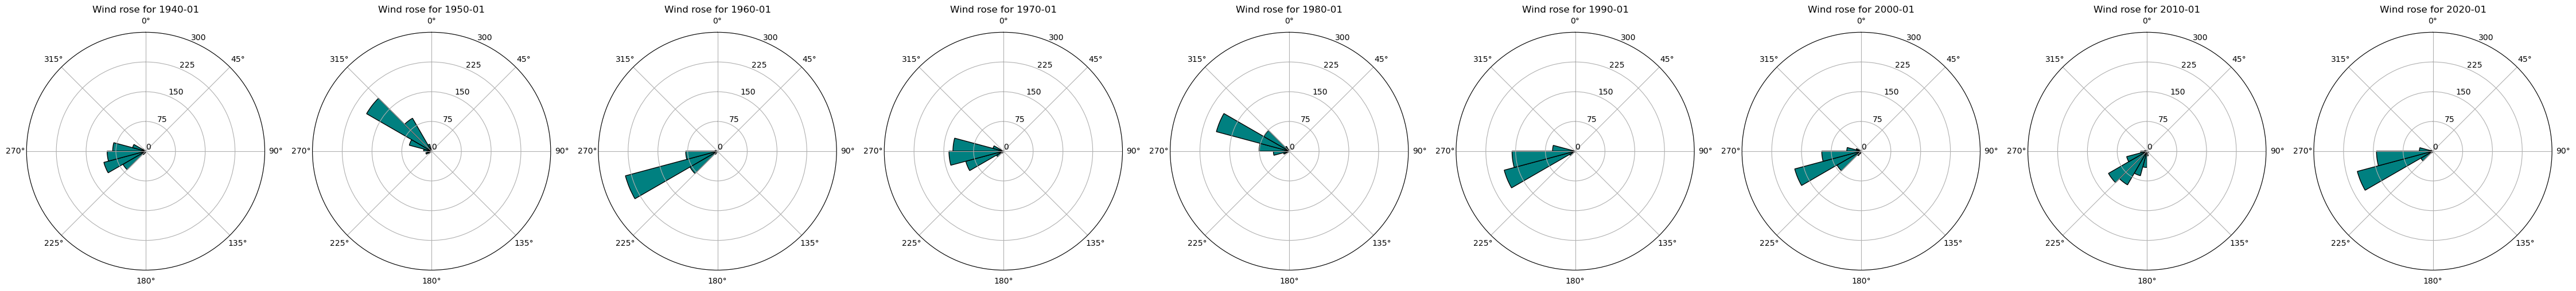

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot wind roses for each year or month-year interval from the input data
def plot_windrose_for_each_interval(excel_file, bin_size=30):

    """
    This script processes wind direction data from an Excel file, bins wind directions into specified intervals (e.g., 30 degrees),
    and generates wind rose plots for each time interval (e.g., yearly or month-year). The radial scale is standardized across all subplots,
    ensuring consistent concentric circles for visual comparison. Each wind rose is titled with the corresponding time interval.

    Parameters:
    - excel_file: Path to the input Excel file containing wind data. Mandatory columns: 'Value' (wind direction in degrees) and 'Year'.
    - bin_size: bin size for the windrose plot (default is 30 degrees).
    """
    try:
        wind_data = pd.read_excel(excel_file, sheet_name="Sheet1")
    except Exception as e:
        raise ValueError(f"Error loading file: {e}")

    if 'Value' not in wind_data.columns or 'Year' not in wind_data.columns:
        raise ValueError("The input file must contain 'Value' and 'Year' columns.")

    if wind_data['Year'].str.contains('_').any():

        wind_data[['Year', 'Month']] = wind_data['Year'].str.split('_', expand=True)
        wind_data['Month'] = wind_data['Month'].astype(int)
        wind_data['Year'] = wind_data['Year'].astype(int)
        wind_data['Year_Month'] = wind_data['Year'].astype(str) + "-" + wind_data['Month'].astype(str).str.zfill(2)

    else:
        wind_data['Year_Month'] = wind_data['Year'].astype(str)  # Default to just year if no month info
    
    bins = np.arange(0, 361, bin_size)
    labels = [f"{i}-{i+bin_size}" for i in bins[:-1]]

    wind_data['Direction Bin'] = pd.cut(wind_data['Value'], bins=bins, labels=labels, include_lowest=True)
    frequency_by_bin = wind_data.groupby(['Year_Month', 'Direction Bin']).size().unstack(fill_value=0)

    if frequency_by_bin.empty:
        raise ValueError("No wind direction data found for the specified time intervals.")  

    num_intervals = len(frequency_by_bin.index)
    if num_intervals == 0:
        raise ValueError("No valid time intervals found in the data.")

    fig, axes = plt.subplots(1, num_intervals, subplot_kw=dict(projection='polar'), figsize=(5 * num_intervals, 5))

    if num_intervals == 1:
        axes = [axes]

    # Shift the angles by half the bin size (to center bins around cardinal directions)
    angles = np.radians(np.arange(0, 360, bin_size)) + np.radians(bin_size / 2)

    manual_rmax = 300

    # Set the constant color to teal
    color_teal = 'teal'

    for i, time_interval in enumerate(frequency_by_bin.index):
        data = frequency_by_bin.loc[time_interval]
        ax = axes[i]

        bars = ax.bar(angles, data, width=np.radians(bin_size), edgecolor='black', color=color_teal)
        ax.set_rmax(manual_rmax) 
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        
        # Modify the title depending on whether it's a single year or month-year
        if '-' in time_interval:
            title = f"Wind rose for {time_interval}"
        else:
            title = f"Wind rose for {time_interval}"
        
        ax.set_title(title)

        radial_ticks = np.linspace(0, manual_rmax, num=5)
        ax.set_rticks(radial_ticks)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

    plt.tight_layout()
    plt.show()

# Example usage
excel_file_path = r'C:\Users\Sunbeam\Desktop\Wind dir_1000mb_1940-2015.xlsx'
plot_windrose_for_each_interval(excel_file_path, bin_size=15)

#### Scripts daily aggregate

##### Script for subsetting large nc file of hourly data with bounding box shp file

In [3]:
import xarray as xr
import arcpy
from pathlib import Path
import warnings
import pandas as pd

def subset_nc_with_bbox(input_nc_file, bbox_shp, pressure_level=1000):
    """
    Subset a NetCDF file using a bounding box shapefile and save the result as a new NetCDF file.

    Parameters:
    - input_nc_file: Path to the input NetCDF file.
    - bbox_shp: Path to the bounding box shapefile containing polygons with FID (or another unique ID).
    - pressure_level: The pressure level to analyze (default is 1000 mb).

    Output:
    - Saves new NetCDF files with subsets for each bounding box in the shapefile, named with the FID (e.g., "input_filename_fid_2.nc").
    """
    input_nc_path = Path(input_nc_file)
    bbox_shp_name = arcpy.Describe(bbox_shp).baseName
    
    with xr.open_dataset(input_nc_file, engine='netcdf4') as ds:
        
        if 'pressure_level' in ds.coords and pressure_level in ds['pressure_level'].values:
            ds = ds.sel(pressure_level=pressure_level)
        else:
            raise ValueError(f"Pressure level {pressure_level} mb not found in the dataset.")

        lat_min = ds['latitude'].min().values
        lat_max = ds['latitude'].max().values
        lon_min = ds['longitude'].min().values
        lon_max = ds['longitude'].max().values

        # Read the bounding box shapefile and reproject to WGS84 (EPSG: 4326)
        spatial_ref = arcpy.SpatialReference(4326)

        with arcpy.da.SearchCursor(bbox_shp, ["FID", "SHAPE@"], spatial_reference=spatial_ref) as cursor:
            for row in cursor:
                fid = row[0]
                shape = row[1]
                extent = shape.extent
                bbox_lat_min = extent.YMin
                bbox_lat_max = extent.YMax
                bbox_lon_min = extent.XMin
                bbox_lon_max = extent.XMax

                if (bbox_lat_min > lat_max or bbox_lat_max < lat_min or
                    bbox_lon_min > lon_max or bbox_lon_max < lon_min):

                    warnings.warn(
                        f"Bounding box for FID {bbox_shp_name} is outside the NetCDF's extent. Skipping.\n"
                        f"Shapefile Bounding Box (lat: {bbox_lat_min}-{bbox_lat_max}, lon: {bbox_lon_min}-{bbox_lon_max})\n"
                        f"NetCDF Bounding Box (lat: {lat_min}-{lat_max}, lon: {lon_min}-{lon_max})"
                    )
                    continue

                print(f"Processing {bbox_shp_name} with bbox (lat: {bbox_lat_min}-{bbox_lat_max}, lon: {bbox_lon_min}-{bbox_lon_max})")

                ds_subset = ds.sel(
                    latitude=slice(bbox_lat_max, bbox_lat_min),
                    longitude=slice(bbox_lon_min, bbox_lon_max)
                )

                output_nc_file = input_nc_path.with_name(f"{input_nc_path.stem}_{bbox_shp_name}.nc")
                ds_subset.to_netcdf(output_nc_file)

                print(f"Subset saved as {output_nc_file}")


input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper.nc"
bbox_shp = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\BBox\BBox_small.shp"
# bbox_shp = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\BBox\BBox_large.shp"
subset_nc_with_bbox(input_nc_file, bbox_shp)

Processing BBox_small with bbox (lat: 48.75313188212691-50.92754861501273, lon: -112.50119741063912--110.16051081082333)
Subset saved as D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper_BBox_small.nc


In [13]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path

def calculate_wind_direction_bins_to_csv(input_nc_file, bin_size=15, cutoff_day=None):
    """
    Processes ERA5 data to calculate the number of hours wind is in a certain direction bin for each month.
    Results are saved in a CSV file.
    
    Parameters:
    - input_nc_file: Path to the input NetCDF file.
    - pressure_level: Pressure level to analyze (default is 1000 mb).
    - bin_size: Wind direction bin size in degrees (default is 15°).
    - cutoff_day: Limits hours per month from day 1 to this cutoff (default None for full month).
    """
    ds = xr.open_dataset(input_nc_file, engine='netcdf4', chunks={'time': 100})

    if 'u' not in ds or 'v' not in ds:
        raise KeyError("Required 'u' and 'v' wind components are missing.")

    wind_dir = (270 - np.rad2deg(np.arctan2(ds['v'], ds['u']))) % 360
    wind_dir = wind_dir.where(~np.isnan(ds['u']) & ~np.isnan(ds['v']), other=np.nan)

    if 'valid_time' in ds:
        times = pd.to_datetime(ds['valid_time'].values)
    elif 'time' in ds:
        times = pd.to_datetime(ds['time'].values)
    else:
        raise KeyError("Time variable not found.")

    if len(wind_dir) != len(times):
        raise ValueError("Mismatch between wind direction and time array lengths.")

    time_diff = np.diff(times)
    if pd.Series(time_diff).mode()[0] != pd.Timedelta(hours=1):
        raise ValueError("Expected hourly data.")

    if cutoff_day is not None:
        mask = times.day <= cutoff_day
        times = times[mask]
        wind_dir = wind_dir.sel(valid_time=times)

    wind_dir_mean = wind_dir.mean(dim=['latitude', 'longitude'], skipna=True)

    df = pd.DataFrame({
        'time': times[:len(wind_dir_mean)],
        'wind_dir': wind_dir_mean.values
    })

    bins = np.arange(0, 360 + bin_size, bin_size)
    bin_labels = [f"{int(b)}-{int(b + bin_size)}" for b in bins[:-1]]

    df = df.dropna(subset=['wind_dir'])
    df['wind_dir_bin'] = pd.cut(df['wind_dir'], bins=bins, labels=bin_labels, right=False)

    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month

    wind_direction_counts = df.groupby(['year', 'month', 'wind_dir_bin']).size().unstack(fill_value=0)

    input_nc_path = Path(input_nc_file)
    output_csv_file = input_nc_path.with_name(f"wind_direction_{bin_size}deg_{input_nc_path.stem}.csv")

    wind_direction_counts.to_csv(output_csv_file)
    print(f"Wind direction bin counts saved to {output_csv_file}")


# Example usage
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper_BBox_small.nc"
bin_size = 15
cutoff_day = 15

# calculate_wind_direction_bins_to_csv(input_nc_file, bin_size=bin_size, cutoff_day=cutoff_day)
calculate_wind_direction_bins_to_csv(input_nc_file, bin_size=bin_size)


Wind direction bin counts saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\wind_direction_15deg_data_stream-oper_BBox_small.csv
